# Library Imports

In [ ]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from collections import Counter

import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision import transforms, models

### Seeds

In [ ]:
# Sets seeds of all Python modules to a given value
def set_seed(seed_value):
    """Set seed for reproducibility"""
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch CPU
    torch.cuda.manual_seed_all(seed_value)  # PyTorch GPU

# Set a seed value
seed_value = 42
set_seed(seed_value)

# Model Import

Import pre-trained *Inception v3* model

In [ ]:
# Load InceptionV3 model pretrained on ImageNet
inceptionv3 = models.inception_v3(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:06<00:00, 16.0MB/s]


In [ ]:
# Set the model to evaluation mode
inceptionv3.eval()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Setup the model for **transfer learning**:

In [ ]:
# Freeze all the parameters except the last fully connected layer
for param in inceptionv3.parameters():
    param.requires_grad = False

# Modify the last layer to fit your number of classes
num_classes = 2  # Assuming CustomDataset has a 'classes' attribute
inceptionv3.fc = nn.Linear(inceptionv3.fc.in_features, num_classes)

# Move the model to the GPU
inceptionv3 = inceptionv3.to(device)

### Parameters import

In [ ]:
# Download parameters
# !curl -LJO https://github.com/Luca-Olivieri/NAML_project/raw/b523c3841d08de86f69d6d651f0776b03cda2e95/incv3_params.pth -o incv3_params.pth
!curl https://github.com/Luca-Olivieri/NAML_project/raw/b523c3841d08de86f69d6d651f0776b03cda2e95/incv3_params.pth -o incv3_params.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 96.1M  100 96.1M    0     0  14.3M      0  0:00:06  0:00:06 --:--:-- 23.7M


# Data Ingestion

Download dataset from GitHub:

In [ ]:
!git clone https://github.com/cialab/neuroendocrine_

Cloning into 'neuroendocrine_'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 67
Receiving objects: 100% (71/71), 246.36 MiB | 24.37 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (63/63), done.


Load images and create 64x64 tiles for training:

In [ ]:
def load_images_with_masks(image_directory, mask_directory):
    images = []
    labels = []
    for image_filename in os.listdir(image_directory):
        if image_filename.endswith(".tif"):
            image_filepath = os.path.join(image_directory, image_filename)
            mask_filename = image_filename + '.png'
            mask_filepath = os.path.join(mask_directory, mask_filename)
            try:
                image = cv2.imread(image_filepath)
                mask = cv2.imread(mask_filepath, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                labels.append(mask)
            except Exception as e:
                print(f"Error loading image {image_filename} or mask: {e}")
    return np.array(images), np.array(labels)

def extract_subimages(images, labels, subimage_size=64, step_size=8):
    subimages = []
    sublabels = []
    for i in range(len(images)):
        image = images[i]
        label = labels[i]
        height, width = image.shape[:2]
        for y in range(0, height - subimage_size + 1, step_size):
            for x in range(0, width - subimage_size + 1, step_size):
                subimage = image[y:y+subimage_size, x:x+subimage_size]
                sublabel = label[y:y+subimage_size, x:x+subimage_size]
                if np.all(sublabel == 0) or np.all(sublabel == 255):
                    subimages.append(subimage)
                    sublabels.append(sublabel[0][0])  # Assuming all values are the same in the sublabel
    return np.array(subimages), np.array(sublabels)

### Dataset creation

Create dataset class for training (that resizez images to 299x299, normalize it and convert it to tensor)
(Normalization values are taken from the inception-v3 pytorch webpage)

In [ ]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        imageResize = cv2.resize(image, (299, 299))

        label = self.labels[idx]
        if self.transform:
            imageResize = self.transform(imageResize)
        return imageResize, label

# Define transformations for resizing and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [ ]:
params_path = "/content/incv3_params.pth"

# Training

Control the training/loading and saving functionalities:

In [ ]:
training = False
save = True

### Training setup

Dataset is very unbalanced, so I create a dataset containing 50% tumor and 50% non tumor subimages.
I tried to trained on the original unbaiased dataset and the network pretty much always predicted tumor (because in training 90% of subimages are tumor)

In [ ]:
def create_dataloader(batch_size=100):

  # Replace 'image_directory' and 'mask_directory' with the paths to your image and mask directories
  image_directory = 'neuroendocrine_/images'
  mask_directory = 'neuroendocrine_/masks'

  images, labels = load_images_with_masks(image_directory, mask_directory)
  train_images, train_labels = extract_subimages(images[:-1], labels)
  val_images, val_labels = extract_subimages(images[-1:], labels)

  print("Shape of the train_images array:", train_images.shape)
  print("Shape of the train_labels array:", train_labels.shape)
  print("Shape of the val_images array:", val_images.shape)
  print("Shape of the val_labels array:", val_labels.shape)

  # labels should be 0 or 1
  train_labels[train_labels == 255] = 1
  val_labels[val_labels == 255] = 1

  del images
  del labels

  del val_images
  del val_labels

  # Assuming train_images and train_labels are your training data
  # Calculate the indices of each class
  class_0_indices = np.where(train_labels == 0)[0]
  class_1_indices = np.where(train_labels == 1)[0]

  # Determine the size of the minority class
  minority_class_size = len(class_0_indices)

  # Randomly sample the same number of samples from the majority class
  undersampled_class_1_indices = np.random.choice(class_1_indices, minority_class_size, replace=False)

  del class_1_indices
  del minority_class_size

  # Concatenate the indices of both classes
  undersampled_indices = np.concatenate([class_0_indices, undersampled_class_1_indices])

  del class_0_indices
  del undersampled_class_1_indices

  # Shuffle the indices to mix the samples from both classes
  np.random.shuffle(undersampled_indices)

  # Use the undersampled indices to create a new balanced dataset
  undersampled_images = train_images[undersampled_indices]
  undersampled_labels = train_labels[undersampled_indices]

  del train_images
  del train_labels

  del undersampled_indices

  # Create the undersampled dataset
  undersampled_dataset = CustomDataset(undersampled_images, undersampled_labels, transform=transform)

  del undersampled_images
  del undersampled_labels

  # Create the data loader for the undersampled dataset
  undersampled_loader = DataLoader(undersampled_dataset, batch_size=batch_size, shuffle=True)

  del undersampled_dataset

  return undersampled_loader

In [ ]:
if training == True:

  batch_size = 100

  undersampled_loader = create_dataloader(batch_size)

In [ ]:
if training == True:

  # Set the last fully connected layer to training mode
  inceptionv3.fc.train()

  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()

  # optimizer = optim.SGD(inceptionv3.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.Adam(inceptionv3.parameters(), lr=0.001)

### Training loop

In [ ]:
# Training loop
def training_loop(num_epochs=1, max_train=200, print_every=10):

  for epoch in range(num_epochs):

    running_loss = 0.0
    count = 0

    for i, (inputs, labels) in enumerate(undersampled_loader, 1):

      # Fetch inputs and labels
      inputs, labels = inputs.to(device), labels.to(device)

      # Initialise gradients
      optimizer.zero_grad()

      # Feedforward
      outputs = inceptionv3(inputs)

      # Backpropagate
      loss = criterion(outputs, labels)
      loss.backward()

      # Update parameters
      optimizer.step()

      # Append loss
      running_loss += loss.item() * inputs.size(0)

      # Print average loss every print_every iterations
      if i % print_every == 0:

          epoch_loss = running_loss / (print_every * len(inputs))
          print(f"Iteration [{i}/{len(undersampled_loader)}], Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
          running_loss = 0.0

      # Iteration limit
      if i >= max_train:
        break

Train the network on the GPU

In [ ]:
if training == True:

  # Proceed with the training loop
  num_epochs = 1
  max_train = 200
  print_every = 10

  training_loop(num_epochs, max_train, print_every)

else:

  # Load the saved dictionary into your model
  state_dict = torch.load(params_path)
  inceptionv3.load_state_dict(state_dict)

### Parameters saving

In [ ]:
save = save and training # save params only if in training mode

if save == True:
  torch.save(inceptionv3.state_dict(), params_path)

# Evaluation

In [ ]:
img_idx = -1 # index of image chosen for evaluation

In [ ]:
path = "/content/neuroendocrine_"

Access input images directory:

In [ ]:
images_dir_path = Path("/content/neuroendocrine_/images")

# List all files in the folder
images_paths = sorted(list(images_dir_path.iterdir()))

# print(images_paths)

Access mask images directory:

In [ ]:
masks_dir_path = Path("/content/neuroendocrine_/masks")

# List all masks in the directory
masks_paths = sorted(list(masks_dir_path.iterdir()))

# print(images_paths)

Evaluated photo:

In [ ]:
images_paths[img_idx], masks_paths[img_idx]

### Target visualisation

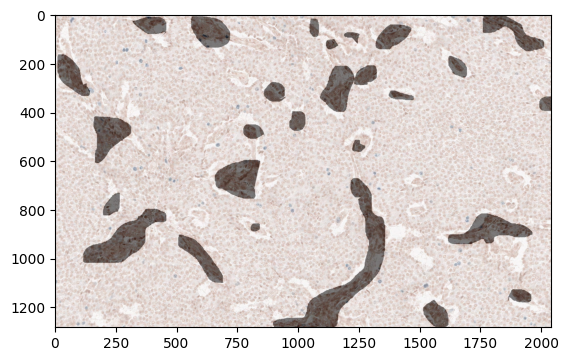

In [ ]:
testImage = cv2.imread(str(images_paths[img_idx]))
testMask = cv2.imread(str(masks_paths[img_idx]))

plt.imshow(testImage)
plt.imshow(testMask, alpha=0.5)

### Prediction

Use last image for testing. Create 64x64 tiles and feed them to the network:

In [ ]:
def predict(image):

  # Assuming 'images' is your list of images and 'testImage' is one such image
  # testImage = cv2.imread('/content/neuroendocrine_/images/HotSpot43_3.tif')
  testImage = image

  subimage_size = 64
  step_size = 8

  height, width = testImage.shape[:2]
  outputHeight = height - height % step_size
  outputWidth = width - width % step_size
  tumorCount = np.zeros((outputHeight, outputWidth))
  count = np.zeros((outputHeight, outputWidth))

  # Move model to GPU
  inceptionv3.eval()

  for row in range(0, height - subimage_size + 1, step_size):
      if row % 50 == 0:
          print('Row ' + str(row) + '/ ' + str(height))
      for col in range(0, width - subimage_size + 1, step_size):
          subimage = testImage[row:row+subimage_size, col:col+subimage_size]

          # Prepare subimage for InceptionV3
          # Resize the subimage using OpenCV
          resized_subimage = cv2.resize(subimage, (299, 299))

          # Define the transformations
          transform = transforms.Compose([
              transforms.ToTensor(),  # Convert image to tensor
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
          ])

          # Apply the transformations and move to GPU
          transformed_subimage = transform(resized_subimage).to(device)

          # Compute output on GPU
          with torch.no_grad():
              output = inceptionv3(transformed_subimage.unsqueeze(0))
              label = torch.argmax(output)

          # Write to matrix
          if label == 1:
              tumorCount[row:row+subimage_size, col:col+subimage_size] += 1
          count[row:row+subimage_size, col:col+subimage_size] += 1

  # Calculate average tumor occurrence per submatrix
  avg = np.divide(tumorCount, count)

  return avg

Predict the mask:

In [ ]:
avg = predict(testImage)

print output of the network

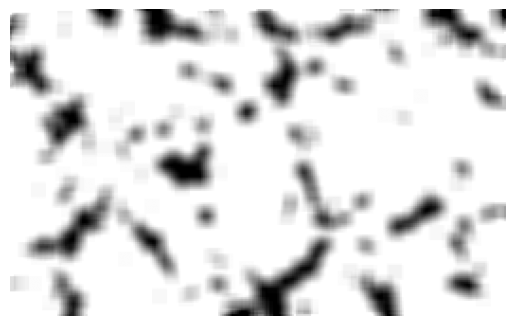

In [ ]:
printAvg = avg*255

# Displaying the numpy array as grayscale
plt.imshow(printAvg, cmap='gray', vmin=0, vmax=255)  # Specify vmin and vmax
plt.axis('off')  # Turn off axis
plt.show()

print prediction (set threshold to 0.5)

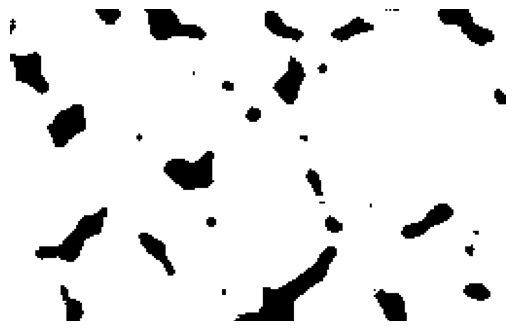

In [ ]:
modelGuess = np.where(avg >= 0.5, 255, 0).astype(np.uint8)[:1283, :2040]

# Displaying the numpy array as grayscale
plt.imshow(modelGuess, cmap='gray', vmin=0, vmax=255)  # Specify vmin and vmax
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
cv2.imwrite('output_image.png', modelGuess)

True

In [ ]:
accuracy = np.sum(modelGuess == testMask[:,:,0]) / modelGuess.size
print("Accuracy: " + str(accuracy))

Accuracy: 0.9382948970702857


Print border

In [ ]:
# Define the disk structuring element
radius = 2
disk_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))

# Apply erosion using the disk structuring element
eroded_mask = cv2.erode(modelGuess, disk_kernel)

tumorBorder = modelGuess - eroded_mask

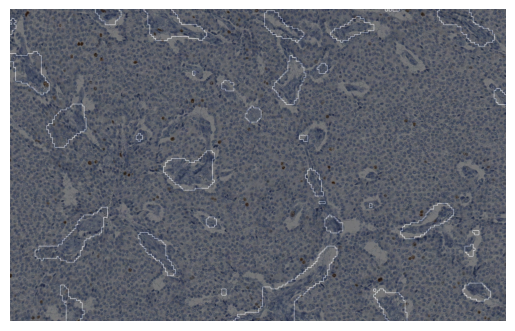

In [ ]:
map_rgb = cv2.cvtColor(tumorBorder, cv2.COLOR_GRAY2RGB)
alpha = 0.5  # Adjust the transparency of the overlaid image
overlay = cv2.addWeighted(testImage[:1283, :2040], alpha, map_rgb, 1 - alpha, 0)

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
